# **AMAZON SHORTAGE DISPUTE**

Mario Raúl García Ramírez

# 0. Prepare libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import warnings
warnings.filterwarnings('ignore')

# 1. Load Data

In [2]:
# Import drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Read and print dataframe
df = pd.read_csv('/content/drive/MyDrive/Project: Amazon supplier/Headers.2025-03-18.na-us_R (2).csv')
df

,Marketplace,Invoice Date,Payment Due Date,Invoice Status,Actual Paid Amount,Paid Amount Currency,Payee,Invoice Creation Date,Randomized Invoice,Invoice Amount,Invoice Currency,Any Deductions,Quantity Variance Amount,Price Variance Amount,Quick Pay Discount Amount,Randomized Latest Child Invoice,Randomized PO
0,US,08/07/2021,14/08/2023,PAID,105.60,USD,GHIJK,08/07/2021,YYRFF3339197,105.60,USD,False,0.00,0.0,2.11,NaN,2G613DYP
1,US,08/07/2021,14/08/2023,PAID,18365.12,USD,ABCDE,08/07/2021,NQWXT9084454,18365.12,USD,False,0.00,0.0,367.56,NQWXT9084454SCR,937VLC8C
2,US,08/07/2021,14/08/2023,PAID,124.50,USD,ABCDE,08/07/2021,RVHXE4032614,124.50,USD,True,24.90,0.0,2.49,NaN,1ILHYU5O
3,US,08/07/2021,14/08/2023,PAID,3646.88,USD,ABCDE,08/07/2021,TJNYH1180722,3646.88,USD,True,39.64,0.0,72.94,NaN,5WSXDYJP
4,US,08/07/2021,14/08/2023,PAID,39213.50,USD,ABCDE,08/07/2021,TYPVC5809220,39979.30,USD,False,0.00,0.0,784.27,TYPVC5809220SCR,5REVZ6PF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43541,US,18/03/2025,17/04/2025,"PROCESSING, PENDING_AMAZON_ACTION",0.00,USD,GHIJK,18/03/2025,XUAUS6165339,9009.00,USD,False,0.00,0.0,0.00,NaN,2TANKZWC
43542,US,18/03/2025,17/04/2025,"PROCESSING, PENDING_AMAZON_ACTION",0.00,USD,GHIJK,18/03/2025,OBQCY6506418,112.99,USD,False,0.00,0.0,0.00,NaN,5FPCXDAO
43543,US,18/03/2025,17/04/2025,"PROCESSING, PENDING_AMAZON_ACTION",0.00,USD,GHIJK,18/03/2025,GESJY0723729,225.98,USD,False,0.00,0.0,0.00,NaN,73U4PNST
43544,US,18/03/2025,17/04/2025,"PROCESSING, PENDING_AMAZON_ACTION",0.00,USD,GHIJK,18/03/2025,QVZET9730990,225.98,USD,False,0.00,0.0,0.00,NaN,7DNNG7YE


# 2. Data cleaning and Preparation

In [4]:
# Parse dates (day/month/year format)
df['Payment Due Date'] = pd.to_datetime(df['Payment Due Date'], dayfirst=True, errors='coerce')
df['Invoice Date']     = pd.to_datetime(df['Invoice Date'],     dayfirst=True, errors='coerce')

# Reference date: today
TODAY = pd.Timestamp('2025-03-18')  # date of the dataset export

# Extract year from Payment Due Date
df['Due Year'] = df['Payment Due Date'].dt.year

# 3. Identifying Shortages

In [5]:
# A shortage exists when Quantity Variance Amount > 0
# (Amazon deducted money because they claim units were missing)

df['Shortage Amount'] = df['Quantity Variance Amount'].clip(lower=0)

shortages = df[df['Shortage Amount'] > 0].copy()
print(f"Total invoices with shortages: {len(shortages):,}")

Total invoices with shortages: 3,336


#4. Total Shortage Amount

In [6]:
# Calculation of Total Shortage Amount
total_shortage = shortages['Shortage Amount'].sum()
print("="*55)
print(f"  OBJECTIVE 1 — TOTAL SHORTAGE AMOUNT")
print("="*55)
print(f"  Total Shortage Amount: ${total_shortage:,.2f} USD")
print("="*55)

  OBJECTIVE 1 — TOTAL SHORTAGE AMOUNT
  Total Shortage Amount: $877,997.87 USD


#5. Current vs Aged Classification

In [7]:
# Current  = due date is within the last 90 days from TODAY
# Aged     = due date is more than 90 days before TODAY

shortages['Days Past Due'] = (TODAY - shortages['Payment Due Date']).dt.days

shortages['Shortage Type'] = np.where(
    shortages['Days Past Due'] <= 90,
    'Current',
    'Aged'
)

current_total = shortages.loc[shortages['Shortage Type'] == 'Current', 'Shortage Amount'].sum()
aged_total    = shortages.loc[shortages['Shortage Type'] == 'Aged',    'Shortage Amount'].sum()

print(f"  Current Shortages (≤ 90 days):  ${current_total:>15,.2f}")
print(f"  Aged Shortages   (> 90 days):   ${aged_total:>15,.2f}")
print(f"  TOTAL:                          ${total_shortage:>15,.2f}")

  Current Shortages (≤ 90 days):  $     313,639.59
  Aged Shortages   (> 90 days):   $     564,358.28
  TOTAL:                          $     877,997.87


# 6. Annual Breakdown of Shortages

In [8]:
annual = (
    shortages
    .groupby('Due Year')['Shortage Amount']
    .agg(Count='count', Total='sum')
    .reset_index()
    .sort_values('Due Year')
)
annual['Cumulative'] = annual['Total'].cumsum()
annual['% of Total'] = (annual['Total'] / total_shortage * 100).round(2)

print("="*55)
print("  OBJECTIVE 2 — ANNUAL BREAKDOWN OF SHORTAGES")
print("="*55)
print(annual.to_string(
    index=False,
    formatters={
        'Total':      '${:,.2f}'.format,
        'Cumulative': '${:,.2f}'.format,
        '% of Total': '{:.2f}%'.format,
    }
))

  OBJECTIVE 2 — ANNUAL BREAKDOWN OF SHORTAGES
 Due Year  Count       Total  Cumulative % of Total
     2021    196   $8,771.47   $8,771.47      1.00%
     2022    576  $25,480.03  $34,251.50      2.90%
     2023    957  $51,669.80  $85,921.30      5.88%
     2024   1380 $486,215.20 $572,136.50     55.38%
     2025    227 $305,861.37 $877,997.87     34.84%


#7. Aged Shortages Per Year

In [9]:
aged_annual = (
    shortages[shortages['Shortage Type'] == 'Aged']
    .groupby('Due Year')['Shortage Amount']
    .agg(Aged_Count='count', Aged_Total='sum')
    .reset_index()
    .sort_values('Due Year')
)
aged_annual['% of Aged Total'] = (aged_annual['Aged_Total'] / aged_total * 100).round(2)

print("="*55)
print("  OBJECTIVE 3 — AGED SHORTAGES PER YEAR")
print("="*55)
print(aged_annual.to_string(
    index=False,
    formatters={
        'Aged_Total':      '${:,.2f}'.format,
        '% of Aged Total': '{:.2f}%'.format,
    }
))

  OBJECTIVE 3 — AGED SHORTAGES PER YEAR
 Due Year  Aged_Count  Aged_Total % of Aged Total
     2021         196   $8,771.47           1.55%
     2022         576  $25,480.03           4.51%
     2023         957  $51,669.80           9.16%
     2024        1342 $478,436.98          84.78%


**Note:** 2025 does not appear in Aged Shortages per Year because those invoices are less than 90 days old as of 18/03/2025 (They are current).

# 8. Visualizations

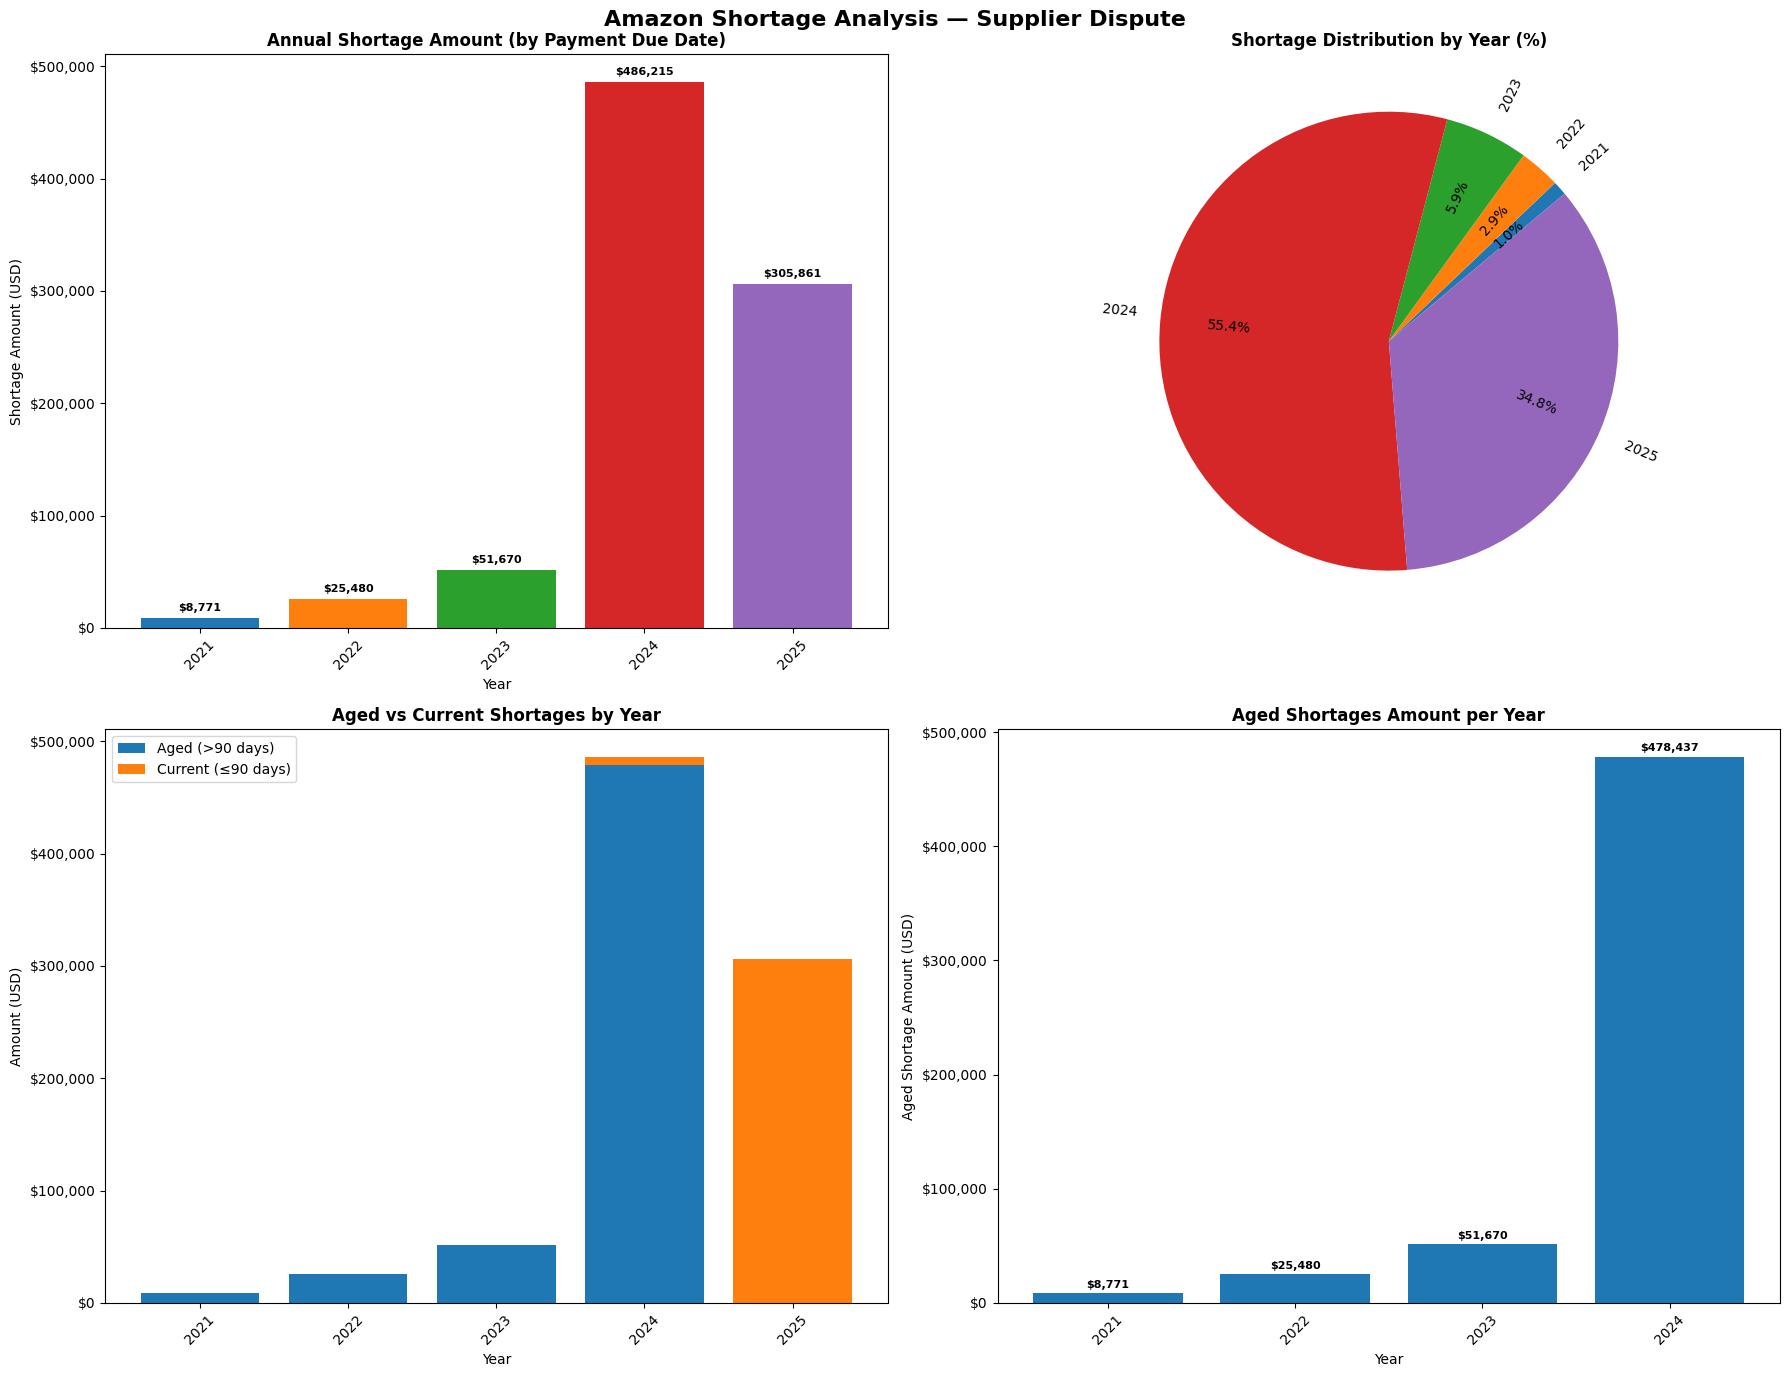


Chart saved as 'shortage_analysis.png'


In [10]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Amazon Shortage Analysis — Supplier Dispute', fontsize=16, fontweight='bold')

colors_main = [f'C{i}' for i in range(6)]

# Chart 1: Annual Shortage Amount (bar)
ax1 = axes[0, 0]
bars = ax1.bar(annual['Due Year'].astype(str), annual['Total'], color=colors_main[:len(annual)])
ax1.set_title('Annual Shortage Amount (by Payment Due Date)', fontweight='bold')
ax1.set_xlabel('Year')
ax1.set_ylabel('Shortage Amount (USD)')
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))
for bar, val in zip(bars, annual['Total']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + total_shortage*0.005,
             f'${val:,.0f}', ha='center', va='bottom', fontsize=8, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)


# Chart 2: % of Total per Year (pie)
ax2 = axes[0, 1]
wedges, texts, autotexts = ax2.pie(
    annual['Total'],
    labels=annual['Due Year'].astype(str),
    autopct='%1.1f%%',
    colors=colors_main[:len(annual)],
    startangle=40,
    pctdistance=0.7,
    rotatelabels=True
)
for wedge, autotext in zip(wedges, autotexts):
    angle = (wedge.theta2 + wedge.theta1) / 2
    rotation_angle = angle
    if 90 < angle < 270:
        rotation_angle -= 180

    autotext.set_rotation(rotation_angle)

ax2.set_title('Shortage Distribution by Year (%)', fontweight='bold')

# Chart 3: Aged vs Current by Year (stacked bar)
ax3 = axes[1, 0]
aged_by_year    = shortages[shortages['Shortage Type']=='Aged'].groupby('Due Year')['Shortage Amount'].sum()
current_by_year = shortages[shortages['Shortage Type']=='Current'].groupby('Due Year')['Shortage Amount'].sum()
years = sorted(shortages['Due Year'].dropna().unique().astype(int))
aged_vals    = [aged_by_year.get(y, 0) for y in years]
current_vals = [current_by_year.get(y, 0) for y in years]
years_str = [str(y) for y in years]
ax3.bar(years_str, aged_vals,    label='Aged (>90 days)',     color='C0')
ax3.bar(years_str, current_vals, bottom=aged_vals, label='Current (≤90 days)', color='C1')
ax3.set_title('Aged vs Current Shortages by Year', fontweight='bold')
ax3.set_xlabel('Year')
ax3.set_ylabel('Amount (USD)')
ax3.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax3.legend()
ax3.tick_params(axis='x', rotation=45)

# Chart 4: Aged Shortages per Year (bar)
ax4 = axes[1, 1]
bars4 = ax4.bar(aged_annual['Due Year'].astype(str), aged_annual['Aged_Total'], color='C0')
ax4.set_title('Aged Shortages Amount per Year', fontweight='bold')
ax4.set_xlabel('Year')
ax4.set_ylabel('Aged Shortage Amount (USD)')
ax4.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))
for bar, val in zip(bars4, aged_annual['Aged_Total']):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + aged_total*0.005,
             f'${val:,.0f}', ha='center', va='bottom', fontsize=8, fontweight='bold')
ax4.tick_params(axis='x', rotation=45)

# Save graphs as png
plt.tight_layout()
plt.savefig('shortage_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nChart saved as 'shortage_analysis.png'")

# 9. Export Results to Excel

In [11]:
with pd.ExcelWriter('shortage_results.xlsx', engine='openpyxl') as writer:
    # Summary sheet
    summary_data = {
        'Metric': [
            'Total Shortage Amount',
            'Current Shortages (≤90 days)',
            'Aged Shortages (>90 days)',
            'Total Invoices with Shortages'
        ],
        'Value': [
            f'${total_shortage:,.2f}',
            f'${current_total:,.2f}',
            f'${aged_total:,.2f}',
            f'{len(shortages):,}'
        ]
    }
    pd.DataFrame(summary_data).to_excel(writer, sheet_name='Summary', index=False)

    # Annual breakdown
    annual.to_excel(writer, sheet_name='Annual Breakdown', index=False)

    # Aged per year
    aged_annual.to_excel(writer, sheet_name='Aged Per Year', index=False)

    # Raw shortage records
    shortages[[
        'Randomized Invoice', 'Randomized PO', 'Invoice Date',
        'Payment Due Date', 'Due Year', 'Invoice Amount',
        'Shortage Amount', 'Days Past Due', 'Shortage Type',
        'Invoice Status', 'Payee'
    ]].sort_values(['Due Year', 'Shortage Amount'], ascending=[True, False])\
      .to_excel(writer, sheet_name='Shortage Detail', index=False)

print("Results exported to 'shortage_results.xlsx'")

Results exported to 'shortage_results.xlsx'


# Final Summary

In [12]:
print("="*55)
print("  FINAL SUMMARY")
print("="*55)
print(f"  Reference Date:              {TODAY.date()}")
print(f"  Total invoices analyzed:     {len(df):,}")
print(f"  Invoices WITH shortages:     {len(shortages):,}")
print(f"  ─────────────────────────────────────────────")
print(f"  TOTAL SHORTAGE AMOUNT:       ${total_shortage:>12,.2f}")
print(f"  ├─ Current (≤ 90 days):      ${current_total:>12,.2f}  ({current_total/total_shortage*100:.1f}%)")
print(f"  └─ Aged   (> 90 days):       ${aged_total:>12,.2f}  ({aged_total/total_shortage*100:.1f}%)")
print("="*55)

  FINAL SUMMARY
  Reference Date:              2025-03-18
  Total invoices analyzed:     43,546
  Invoices WITH shortages:     3,336
  ─────────────────────────────────────────────
  TOTAL SHORTAGE AMOUNT:       $  877,997.87
  ├─ Current (≤ 90 days):      $  313,639.59  (35.7%)
  └─ Aged   (> 90 days):       $  564,358.28  (64.3%)
